# Video Classification with VideoMAE


In this notebook, we will show how to fine-tune [**VideoMAE**](https://arxiv.org/abs/2203.12602) model for a classification task. The official release is in [`torch`](https://github.com/MCG-NJU/VideoMAE). This notebook is the [`keras`](https://github.com/innat/VideoMAE) reimplementation.

## VideoMAE

Video masked autoencoders (**VideoMAE**) are data-efficient learners for self-supervised video pre-training (SSVP). The [checkpoints](https://github.com/innat/VideoMAE/blob/main/MODEL_ZOO.md) of **VideoMAE** are **pre-trained (PT)** and **fine-tuned (FT)**. The **PT** models are masked autoencoder, trained as a self-supervised manner and **FT** models are further fine-tuned models, trained on dataset like [Kinetics-400](https://www.deepmind.com/open-source/kinetics), [Something-Something-V2](https://developer.qualcomm.com/software/ai-datasets/something-something) and [UCF101](https://www.crcv.ucf.edu/data/UCF101.php). The pre-trained and fine-tuned models are listed in [MODEL_ZOO.md](https://github.com/innat/VideoMAE/blob/main/MODEL_ZOO.md). Following are some hightlights.


### Kinetics-400

| Backbone | \#Frame | Top-1 | Top-5 | Params [FT] MB | Params [PT] MB) | FLOPs |
 | :--: | :--: | :---: | :---: | :---: | :---: |  :---: |
  ViT-S    | 16x5x3  | 79.0 | 93.8   | 22 | 24 |  57G |
  ViT-B    | 16x5x3  | 81.5  | 95.1  | 87 | 94 |  181G |
  ViT-L    | 16x5x3  | 85.2  | 96.8  | 304 | 343 |  - |
  ViT-H    | 16x5x3  | 86.6 | 97.1   | 632 | ? |  - |


### Something-Something V2

| Backbone | \#Frame | Top-1 | Top-5 | Params [FT] MB | Params [PT] MB | FLOPs |
| :------: | :-----: | :---: | :---: | :---: | :---: | :---: |
|  ViT-S    | 16x2x3 | 66.8 | 90.3 | 22 | 24 |  57G |
|  ViT-B    | 16x2x3 | 70.8  | 92.4  | 86 | 94 |  181G |

### UCF101

| Backbone | \#Frame | Top-1 | Top-5 | Params [FT] MB | Params [PT] MB | FLOPS |
| :---: | :-----: | :---: | :---: | :---: | :---: | :---: |
|  ViT-B   |  16x5x3  | 91.3 |  98.5 | 86 | 94 |  181G |


---


In this quick demonstration, we will show how to fine-tune a custom dataset with **VideoMAE** models. We will be using a videomae's **FT** checkpoint as a backbone and add a custom head on top of it.

## Dataset

This is where you can use your own data. For demonstration purpose, we have created a sub-set of Kintetics dataset with `5` categories to represent a custom dataset. Here is the link of [KineticsTop5](https://huggingface.co/datasets/innat/KineticsTop5) datast. You can choose your own dataset and dataloader.





In [2]:
!pip install huggingface_hub decord -q


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader

from huggingface_hub import hf_hub_download
from mpl_toolkits.axes_grid1 import ImageGrid
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

DEVICE = 'TPU' # 'GPU', 'TPU'

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D1011 17:40:20.101360558  330754 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1011 17:40:20.101385642  330754 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1011 17:40:20.101389662  330754 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1011 17:40:20.101392641  330754 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1011 17:40:20.101395278  330754 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1011 17:40:20.101397992  330754 config.cc:119]     

In [4]:
if DEVICE == 'GPU':
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    [tf.config.experimental.set_memory_growth(pd, True) for pd in physical_devices]
    strategy = tf.distribute.MirroredStrategy()
else:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    keras.mixed_precision.set_global_policy("mixed_bfloat16")
    
HOME = os.getcwd()
tf.__version__, HOME, strategy

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

('2.12.0',
 '/kaggle/working',
 <tensorflow.python.distribute.tpu_strategy.TPUStrategyV2 at 0x7ce6209169a0>)

## Utils

In [5]:
def denormalize(z):
    mean = np.array([0.485, 0.456, 0.406])
    variance = np.array([np.square(0.225), np.square(0.225), np.square(0.225)])
    std = np.sqrt(variance)
    x = (z * std) + mean
    x = x * 255
    return x

def show_sequence(seq, sample=8, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    assert (seq.shape[-1] == 3)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, denormalize(seq)):
        ax.imshow(img.astype('uint8'))
        ax.set_axis_off()
    plt.show()
    return

## Data



In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

In [ ]:
hf_dataset_identifier = "innat/KineticsTop5"
filename = "kinetics_top5.zip"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)
!unzip -q {file_path}

In [6]:
train_set = f'{HOME}/data/train'
test_set = f'{HOME}/data/test'
class_folders = os.listdir(train_set)
label2id = {label:i for i, label in enumerate(class_folders)}
id2label = {v:k for k, v in label2id.items()}
id2label

{0: 'reading_book',
 1: 'sneezing',
 2: 'reading_newspaper',
 3: 'squat',
 4: 'opening_bottle'}

In [7]:
def create_dataframe(path):
    data = []

    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)
        if os.path.isdir(class_dir) and class_name in label2id:
            for video_file in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': label2id[class_name],
                    'class_name': class_name
                })

    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_df = create_dataframe(train_set)
test_df = create_dataframe(test_set)
train_df.shape, test_df.shape

((3121, 3), (243, 3))

In [8]:
test_df.head()

,video_path,label,class_name
0,/kaggle/working/data/test/sneezing/uZyZTplG4eo...,1,sneezing
1,/kaggle/working/data/test/reading_book/jpTXH1E...,0,reading_book
2,/kaggle/working/data/test/sneezing/ngmWeyw8lG8...,1,sneezing
3,/kaggle/working/data/test/reading_book/I131OC6...,0,reading_book
4,/kaggle/working/data/test/squat/Wv1DTzoP-8M.mp4,3,squat


# Data Loader

Reading the video data from dataloader in training time can be challenging. We can leverage [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) format, but due to the cost of disk space, we will skip that. For now, we will be using [`decord`](https://github.com/dmlc/decord) for video reader. It supports both GPUs and TPUs.



In [9]:
input_size=224
num_frame=16
sampling_rate=4
batch_size=16 * strategy.num_replicas_in_sync

In [10]:
def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(input_size, input_size)
    )

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([None, None, None, 3])
    return video, tf.cast(label, dtype=tf.float32)

The raw **Kinetics** data comes with variable size of **input frame** and **frame size**. We will resize the video to the target shape (i.e. `224`). For **VideoMAE** model, the clip length is `16`. We will use frame rate `4` which is the stride or step from a frame to next frame. We will also take `1` clip from a video. However, in literature for evaluation, it's common to take `num_clips > 1` from each clip and average the results for final prediction For **VideoMAE**, check the official [note](https://github.com/MCG-NJU/VideoMAE/blob/main/MODEL_ZOO.md#note) on this. But here for simplicity cause, we will skip that.


Sampling strategy for frame selection is another important factor which might need another attention. It can significantly differs the reported scores. In this notebook, we will be using [uniform sampling](https://gist.github.com/innat/205075992360d8d7a241c7f1013866a8) for frame selection.

In [11]:
def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples-1) * frame_rate, tf.float32),
        num_samples
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)


def clip_generator(
    image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224
):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)

    video = tf.stack(clips_list)
    video = tf.reshape(
        video, [num_clips*num_frames, crop_size, crop_size, 3]
    )
    return video


In [12]:
processing_model = keras.Sequential(
    [
        layers.Rescaling(scale=1./255.),
        layers.Normalization(
            mean=[0.485, 0.456, 0.406],
            variance=[np.square(0.225), np.square(0.225), np.square(0.225)]
        )
    ]
)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df['video_path'].values, df['label'].values)
    )
    ds = ds.repeat()
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(
        lambda x, y: (clip_generator(x, num_frame, sampling_rate, num_clips=1), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.map(lambda x, y: (processing_model(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
train_ds = create_dataloader(
    train_df, batch_size, shuffle=True
)

test_ds = create_dataloader(
    test_df, batch_size, shuffle=False
)

**Visualize**

In [14]:
temp_ds = create_dataloader(
    test_df, 8, shuffle=False
)
x, y = next(iter(temp_ds))
x.shape, y

(TensorShape([8, 16, 224, 224, 3]),
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 0., 1., 0., 3., 3., 4., 2.], dtype=float32)>)

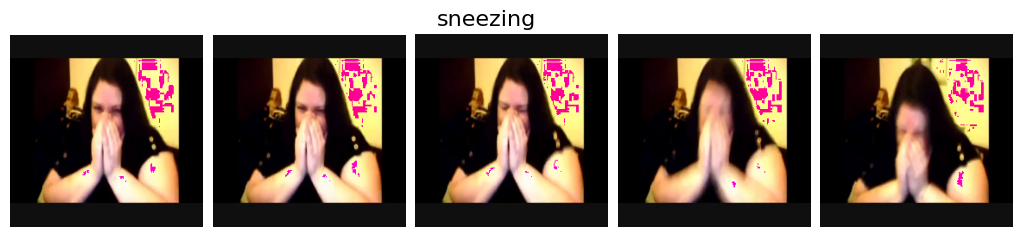

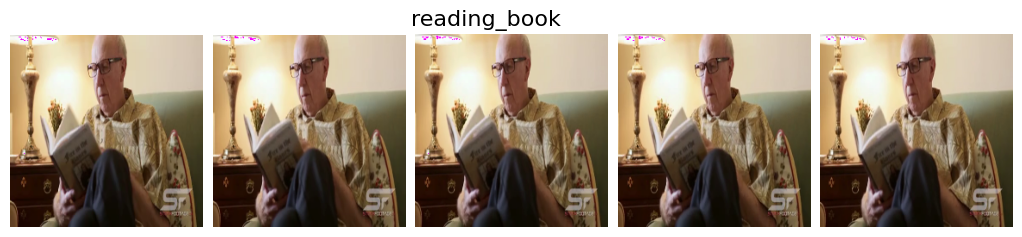

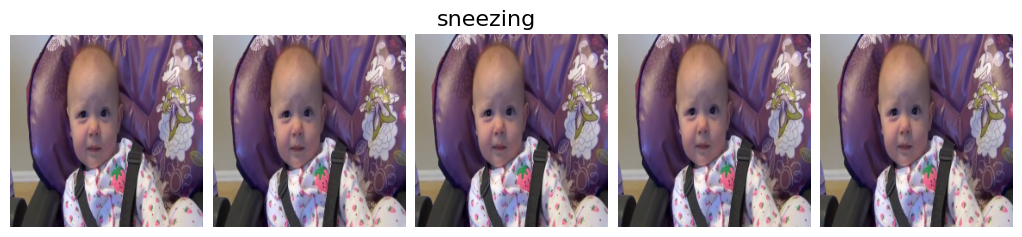

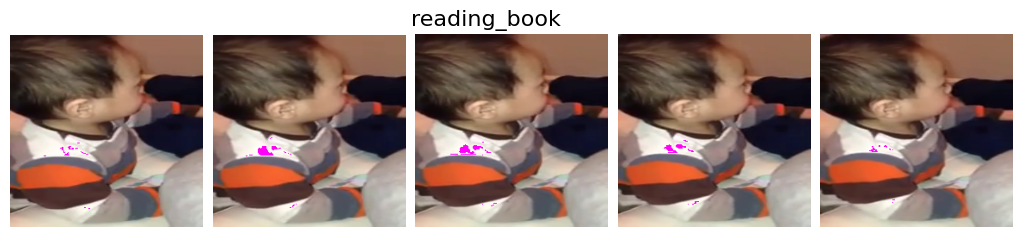

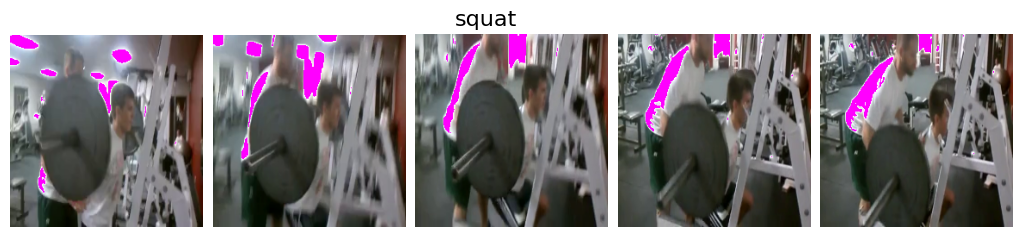

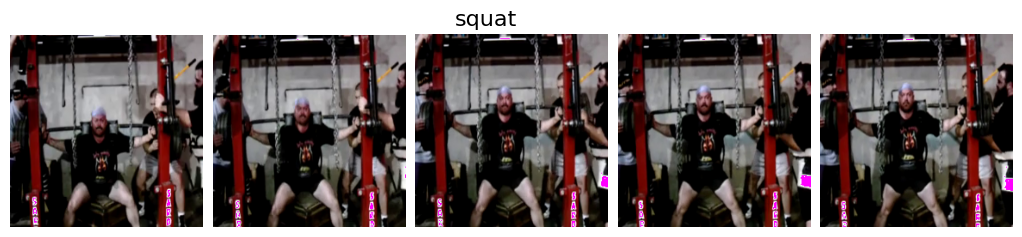

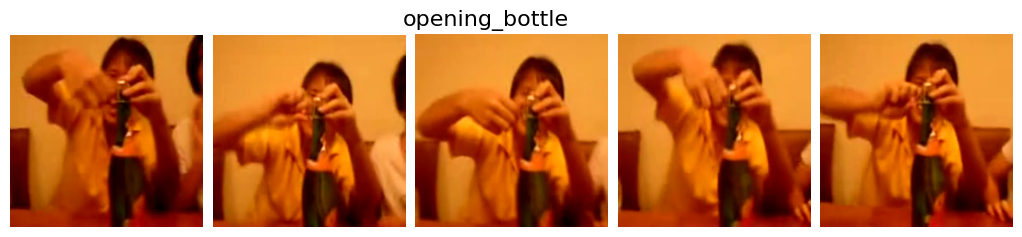

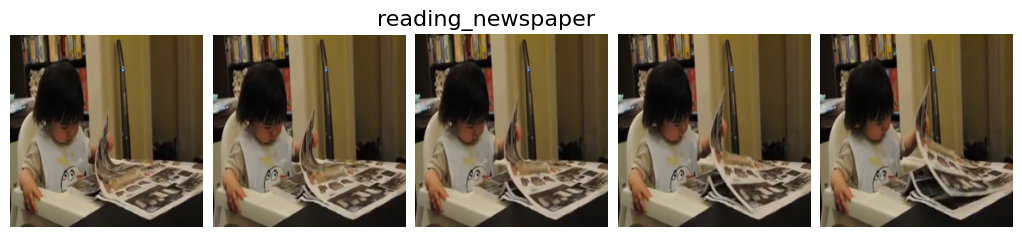

In [15]:
for i in range(len(x)):
    show_sequence(
        x.numpy()[i], sample=5, title=id2label[y[i].numpy()]
    )

# Model

As mentioned, we are using a custom **Kinetics-5** dataset. And so for backbone from **VideoMAE** model, we will be using a checkpoint that is trained on **Something-Something-V2** model.

In [ ]:
backbone_name = "TFVideoMAE_S_SSv2_16x224_FT" #@param ["TFVideoMAE_S_SSv2_16x224_FT", "TFVideoMAE_B_SSv2_16x224_FT"]

In [ ]:
!wget -f'https://github.com/innat/VideoMAE/releases/download/v1.1/{backbone_name}.zip'
!unzip -q f'/content/{backbone_name}.zip'

In [16]:
with strategy.scope():
    # fine-tuned model on ucf101
    finetune_videomae = keras.models.load_model(
        '/kaggle/input/ss-db-v2/small/TFVideoMAE_S_SSv2_16x224_FT', compile=False
    )
    finetune_videomae.trainable = False

    # downstream model
    model = keras.Sequential([
        finetune_videomae,
        layers.Dense(len(class_folders), dtype='float32', activation=None)
    ])

    # compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
          learning_rate=5e-4,
          weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
          keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
          keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc@3")
        ]
    )

In [17]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(test_df) // batch_size,
    epochs=20,
)

Epoch 1/20
24/24 [==============================] - 578s 23s/step - loss: 2.1360 - acc@1: 0.2630 - acc@3: 0.6553 - val_loss: 2.1869 - val_acc@1: 0.2109 - val_acc@3: 0.6719
Epoch 2/20
24/24 [==============================] - 430s 19s/step - loss: 1.8021 - acc@1: 0.3434 - acc@3: 0.7269 - val_loss: 2.0579 - val_acc@1: 0.2578 - val_acc@3: 0.6875
Epoch 3/20
24/24 [==============================] - 400s 17s/step - loss: 1.6478 - acc@1: 0.3949 - acc@3: 0.7633 - val_loss: 1.9006 - val_acc@1: 0.3047 - val_acc@3: 0.7266
Epoch 4/20
24/24 [==============================] - 431s 18s/step - loss: 1.4968 - acc@1: 0.4258 - acc@3: 0.7998 - val_loss: 1.8003 - val_acc@1: 0.3594 - val_acc@3: 0.7656
Epoch 5/20
24/24 [==============================] - 395s 17s/step - loss: 1.4062 - acc@1: 0.4668 - acc@3: 0.8275 - val_loss: 1.7072 - val_acc@1: 0.3828 - val_acc@3: 0.7656
Epoch 6/20
24/24 [==============================] - 557s 24s/step - loss: 1.3340 - acc@1: 0.4870 - acc@3: 0.8333 - val_loss: 1.6351 - val_ac

# Inference

In [52]:
test_sample = 'reading_book/BFYBAg9fSL4.mp4' #@param ["opening_bottle/0npur3PQMHA.mp4", "reading_newspaper/26N2XO29YU8.mp4", "reading_book/BFYBAg9fSL4.mp4", "sneezing/6k-Uob0qzW4.mp4", "squat/6_jT33BqtK8.mp4"]

In [53]:
def read_video(file_path):
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(input_size, input_size)
    )

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

sample_ds = read_video(os.path.join('/kaggle/working/data/test', test_sample))
sample_ds = clip_generator(sample_ds, num_frame, sampling_rate, num_clips=1)
sample_ds = processing_model(sample_ds)
sample_ds.shape

TensorShape([1, 16, 224, 224, 3])

In [54]:
y_pred = model(sample_ds, training=False)
y_pred = y_pred.numpy().argmax(-1)[0]
y_pred

0

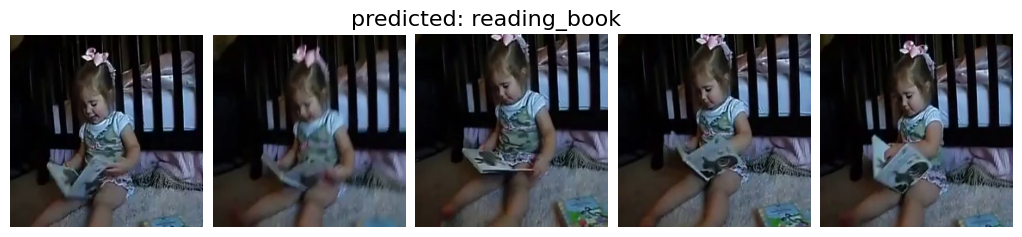

In [55]:
show_sequence(
    sample_ds.numpy().squeeze(), sample=5, title='predicted: ' + str(id2label[y_pred])
)